# Loading the DIGITS Dataset

Don't forget to change runtime type to select a GPU if you are running this notebook in Google Colab.

In [1]:
import tensorflow as tf
import numpy as np
from keras.datasets import mnist
import pandas as pd
from sklearn.model_selection import train_test_split

seed = 10
np.random.seed(seed)

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

data = pd.read_csv('digits.csv')
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)
train_X = np.array(train_X).reshape(train_X.shape[0], 28, 28)
test_X = np.array(test_X).reshape(test_X.shape[0], 28, 28)

TensorFlow version: 2.15.0
Num GPUs Available:  1


# Exploratory Data Analysis

In [2]:
print(f'Train+Validation data shape: {train_X.shape}')
print(f'Test data shape: {test_X.shape}')

Train+Validation data shape: (7315, 28, 28)
Test data shape: (1829, 28, 28)


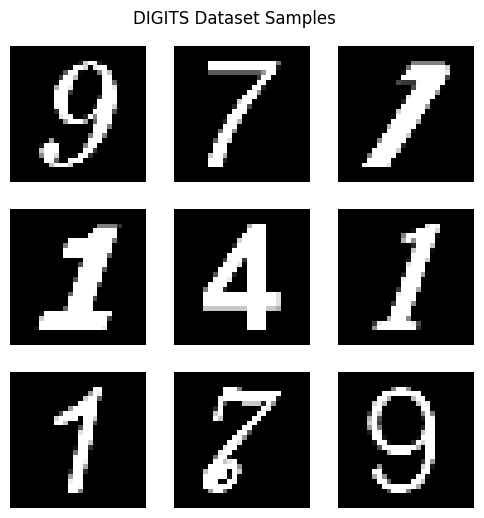

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_X[5*i], cmap = 'gray')
    plt.axis('off')
plt.suptitle('DIGITS Dataset Samples', y=0.94);

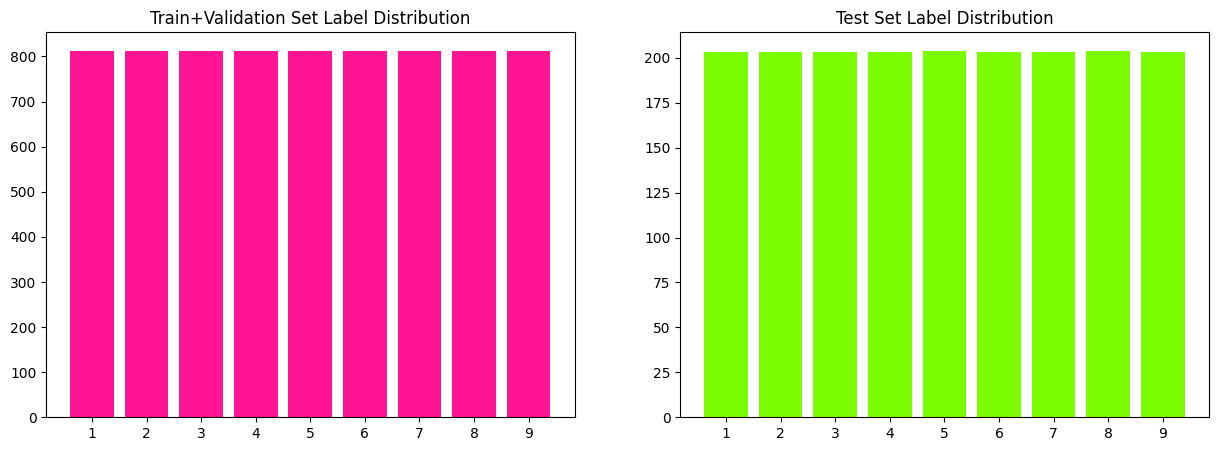

In [4]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
x, y = np.unique(train_y, return_counts=True)
plt.bar(x, y, color = 'deeppink')
plt.xticks(x); plt.title('Train+Validation Set Label Distribution');

plt.subplot(1, 2, 2)
x, y = np.unique(test_y, return_counts=True)
plt.bar(x, y, color = 'lawngreen')
plt.xticks(x); plt.title('Test Set Label Distribution');

CPU times: user 14.9 s, sys: 374 ms, total: 15.2 s
Wall time: 14.8 s


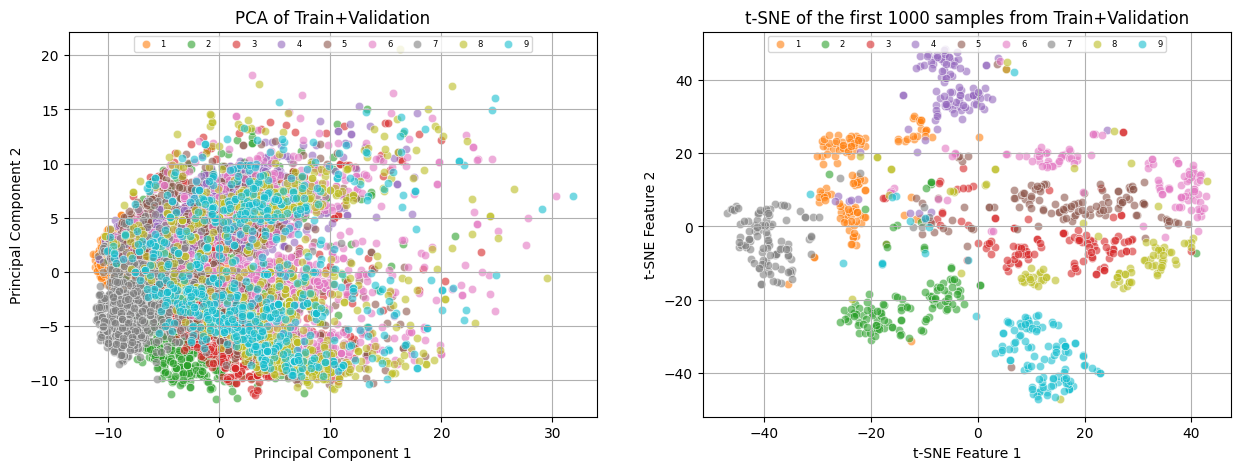

In [5]:
%%time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

colors = plt.colormaps.get_cmap("tab10")

scaler = StandardScaler()
flat = train_X.reshape(-1, 28*28)
scaled_train = scaler.fit_transform(flat)

pca = PCA(n_components=2)
r_PCA = pca.fit_transform(scaled_train)
tsne = TSNE(n_components=2, random_state=seed)
r_TSNE = tsne.fit_transform(scaled_train[:1000])

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for digit in np.unique(train_y):
    idx = train_y == digit
    plt.scatter(r_PCA[idx, 0], r_PCA[idx, 1], color=colors(digit/10), label=digit, alpha=0.6, edgecolors='w', linewidth=0.5)

plt.title('PCA of Train+Validation')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='upper center', ncol=len(np.unique(train_y)), fontsize=6)
plt.grid(True)

plt.subplot(1, 2, 2)
for digit in np.unique(train_y[:1000]):
    indices = train_y[:1000] == digit
    plt.scatter(r_TSNE[indices, 0], r_TSNE[indices, 1], color=colors(digit/10), label=digit, alpha=0.6, edgecolors='w', linewidth=0.5)

plt.title('t-SNE of the first 1000 samples from Train+Validation')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(loc='upper center', ncol=len(np.unique(train_y)), fontsize=6)
plt.grid(True)

We observe that t-SNE provides better clusters with the MNIST dataset compared to PCA. It is also obvious that the problem is not linearly seperable. Hence, a CNN will be trained.

# Preprocessing the DIGITS Dataset

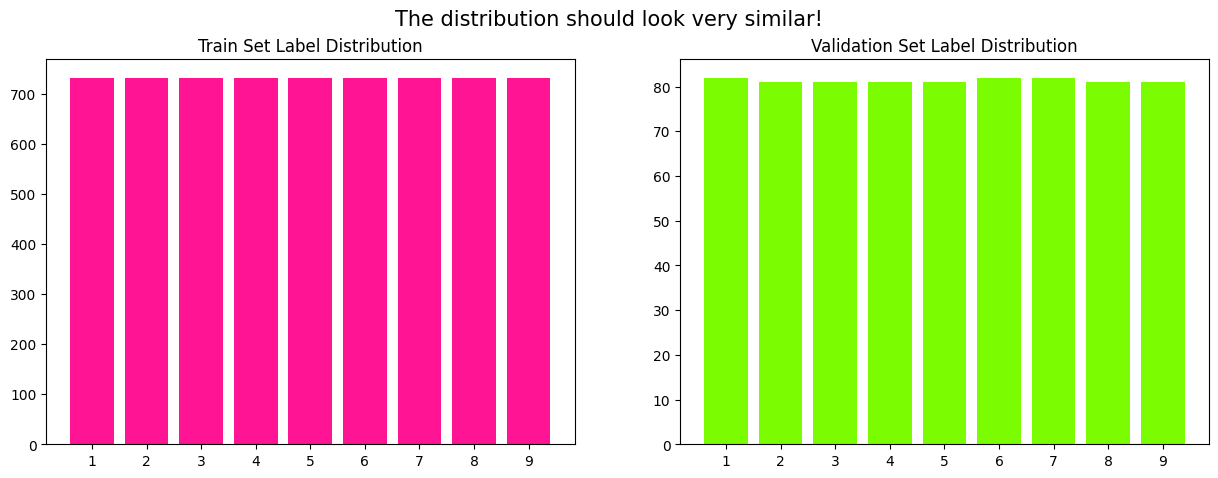

In [6]:
train_X = (train_X).astype('float32')
test_X = (test_X).astype('float32')
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.1, random_state=seed, stratify=train_y)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
x, y = np.unique(train_y, return_counts=True)
plt.bar(x, y, color = 'deeppink')
plt.xticks(x); plt.title('Train Set Label Distribution');

plt.subplot(1, 2, 2)
x, y = np.unique(val_y, return_counts=True)
plt.bar(x, y, color = 'lawngreen')
plt.xticks(x); plt.title('Validation Set Label Distribution');
plt.suptitle('The distribution should look very similar!', fontsize=15);

We need to match the specified format in ```TensorFlow``` documentation for CNNs. ```[batch_size, height, width, channels]```

In [7]:
train_X = tf.expand_dims(train_X, axis=-1)
val_X = tf.expand_dims(val_X, axis=-1)
test_X = tf.expand_dims(test_X, axis=-1)

train_X = np.repeat(train_X, 3, axis=-1)
val_X = np.repeat(val_X, 3, axis=-1)
test_X = np.repeat(test_X, 3, axis=-1)

train_X = tf.image.resize(train_X, [32, 32], method='bilinear')
val_X = tf.image.resize(val_X, [32, 32], method='bilinear')
test_X = tf.image.resize(test_X, [32, 32], method='bilinear')

print(f'Train data shape: {train_X.shape}')
print(f'Validation data shape: {val_X.shape}')
print(f'Test data shape: {test_X.shape}')

input_shape = train_X.shape[1:]

Train data shape: (6583, 32, 32, 3)
Validation data shape: (732, 32, 32, 3)
Test data shape: (1829, 32, 32, 3)


We also need to do one-hot encoding of the labels. ```tf.one_hot()``` expects zero based categories so we do a shift first.

In [8]:
train_y = tf.one_hot(train_y-1, depth = 9)
val_y = tf.one_hot(val_y-1, depth = 9)
test_y = tf.one_hot(test_y-1, depth = 9)

# Transfer Learning with ConvNeXt

In [9]:
ConvNeXt = tf.keras.applications.ConvNeXtBase(
    input_shape=(32, 32, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing=True
)

In [10]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Freeze weights.
ConvNeXt.trainable = False

# Create an input layer with shape (32, 32, 3)
inputs = tf.keras.Input(shape=(32, 32, 3))
# Connect EfficientNetV2S to the input
x = ConvNeXt(inputs)
# Add a Dense layer with 9 units and softmax activation as the classifier
outputs = layers.Dense(9, activation='softmax')(x)

# Create a Model connecting input and output
tl_model = tf.keras.Model(inputs=inputs, outputs=outputs, name='model')

# Defining early stopping criteria.
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    mode='max',
    baseline=None,
    restore_best_weights=True,
)
# Defining metrics to monitor.
metrics=['accuracy', 'AUC', 'Recall', 'Precision']

tl_model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=metrics)

epochs = 300
batch_size = 32

data_gen = ImageDataGenerator(
    rotation_range=5,        # Random rotations between -20 to 20 degrees
    width_shift_range=0.1,    # Random horizontal shifts up to 10% of the total width
    height_shift_range=0.1,   # Random vertical shifts up to 10% of the total height
    shear_range=0.1,          # Shear angle in counter-clockwise direction as radians
    zoom_range=0.1,           # Random zoom
    horizontal_flip=False,    # Randomly flip inputs horizontally
    fill_mode='nearest'       # Fill in missing pixels with the nearest filled value
)

train_generator = data_gen.flow(train_X, train_y, batch_size=batch_size)

history = tl_model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=len(train_X) // batch_size,
    validation_data=(val_X, val_y),
    callbacks=[callback]
)

# Display model summary
tl_model.summary()

Epoch 1/300
205/205 [==============================] - 51s 148ms/step - loss: 0.6327 - accuracy: 0.8168 - auc: 0.9757 - recall: 0.7129 - precision: 0.9227 - val_loss: 0.2976 - val_accuracy: 0.9221 - val_auc: 0.9947 - val_recall: 0.8866 - val_precision: 0.9502
Epoch 2/300
205/205 [==============================] - 17s 85ms/step - loss: 0.2450 - accuracy: 0.9374 - auc: 0.9964 - recall: 0.9148 - precision: 0.9610 - val_loss: 0.1851 - val_accuracy: 0.9495 - val_auc: 0.9983 - val_recall: 0.9303 - val_precision: 0.9687
Epoch 3/300
205/205 [==============================] - 16s 78ms/step - loss: 0.1773 - accuracy: 0.9519 - auc: 0.9981 - recall: 0.9363 - precision: 0.9703 - val_loss: 0.1547 - val_accuracy: 0.9604 - val_auc: 0.9987 - val_recall: 0.9481 - val_precision: 0.9775
Epoch 4/300
205/205 [==============================] - 16s 79ms/step - loss: 0.1463 - accuracy: 0.9589 - auc: 0.9982 - recall: 0.9502 - precision: 0.9745 - val_loss: 0.1309 - val_accuracy: 0.9563 - val_auc: 0.9992 - val_re

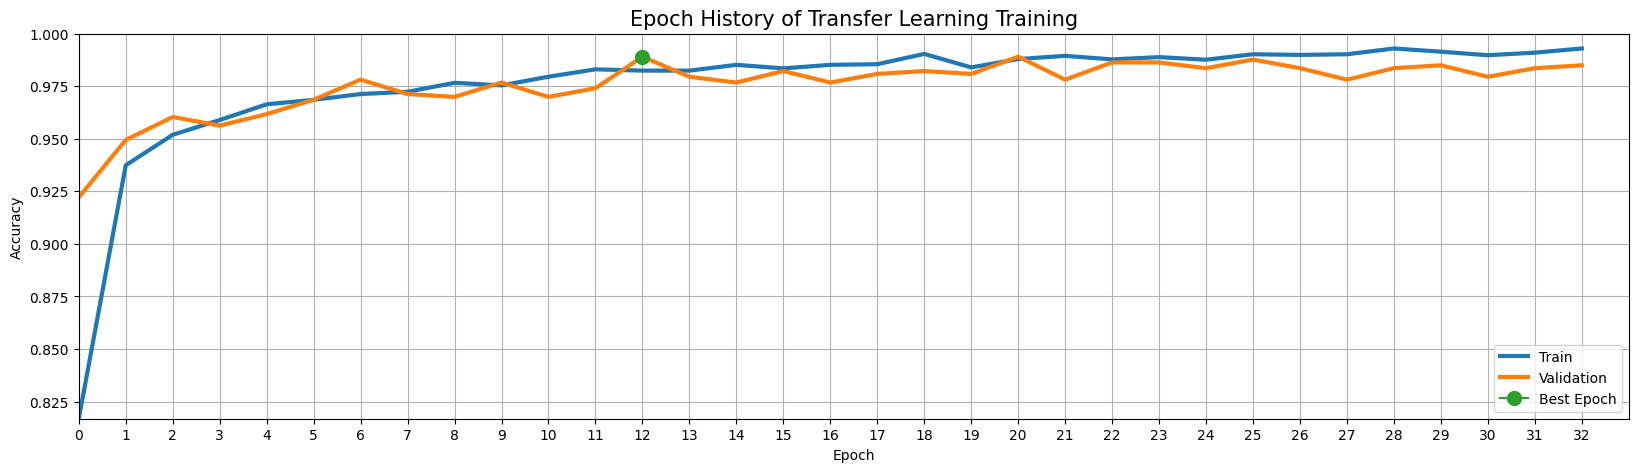

In [11]:
best_epoch = np.argmax(history.history['val_accuracy'])
val_accuracy = history.history['val_accuracy'][best_epoch]
train_accuracy = history.history['accuracy'][best_epoch]

plt.figure(figsize=(20, 5))
plt.plot(history.history['accuracy'], label='Train', lw=3)
plt.plot(history.history['val_accuracy'], label = 'Validation', lw=3)
plt.plot(best_epoch, val_accuracy, marker='o', label='Best Epoch', markersize=10)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([min(np.min(history.history['val_accuracy']), np.min(history.history['accuracy'])), 1])
plt.xlim([0, len(history.history['accuracy'])])
plt.xticks(np.arange(0, len(history.history['accuracy'])))
plt.legend(loc='lower right')
plt.grid()
plt.title('Epoch History of Transfer Learning Training', fontsize=15, loc='center');

# Performance of the Model with Transfer Learning on ConvNeXt.

In [12]:
import pandas as pd
from absl import logging as absl_logging

test_loss, test_accuracy, test_auc, test_recall, test_precision = tl_model.evaluate(test_X,  test_y, verbose=0)

results = dict()
for metric in metrics:
    results[metric] = [history.history[f'{metric.lower()}'][best_epoch], history.history[f'val_{metric.lower()}'][best_epoch]]
test_col = [test_accuracy, test_auc, test_recall, test_precision]

result_df = pd.DataFrame.from_dict(results, orient='index', columns=['Train', 'Validation'])
result_df['Test'] = test_col
result_df.index = ['Accuracy'] + metrics[1::]

display(result_df)
absl_logging.set_verbosity(absl_logging.ERROR)
tf.get_logger().setLevel('ERROR')

,Train,Validation,Test
Accuracy,0.982445,0.989071,0.977583
AUC,0.999803,0.999737,0.999572
Recall,0.977866,0.980874,0.973756
Precision,0.986449,0.990345,0.983435


# Visualising Results on Test Set

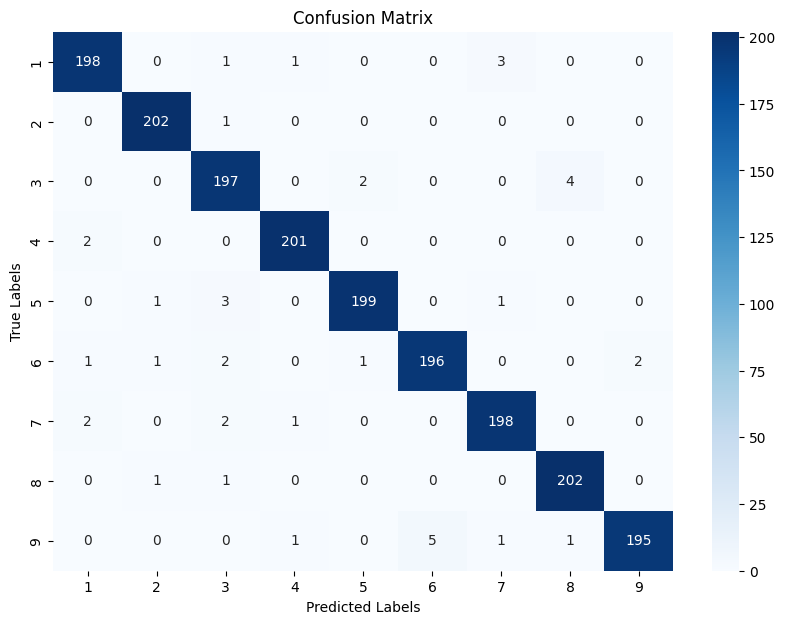

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = tl_model.predict(test_X, verbose=None)
predicted_classes = np.argmax(predictions, axis=1)+1 # Class offset +1

true_classes = np.argmax(test_y, axis=1)+1 # Class offset +1
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 10), yticklabels=np.arange(1, 10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix');